## SSMI Ice data
### Cartopy quicklook

This notebook provides guidance to visualize SSMI data after it has been processed from raw binary data to csv data with columns of ice_concentration, latitude, and longitude.  It regrids the data to the users choice (default = 0.25x0.25 degree) by declaring the number of columns of latitude and longitude.

There is also timing components built in to see if and where the ingest/gridding/plotting can be spead up

__pyversion__==3.7   
__author__==S.Bell

In [18]:
import numpy as np
import datetime

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import timeit

In [19]:
filein = '/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1978/bt_19781231_n07_v3.1_n.csv'
df = pd.read_csv(filein)


In [20]:
df.describe()

,grid_area,ice_conc,latitude,longitude
count,136192.000000,136192.000000,136192.000000,136192.000000
mean,555.540872,16.472752,57.624520,17.489821
std,65.681213,36.083450,12.239096,104.975745
min,382.659000,0.000000,31.102670,-180.000000
25%,504.298000,0.000000,47.900800,-70.346180
50%,561.330500,0.000000,56.940085,6.666425
75%,609.645500,0.000000,66.304733,115.033140
max,664.449000,100.000000,89.836820,179.813980


## options for thinning data out

In [21]:
### set a range of lats and lons
# not advised as this messes with gridding assumptions later
#df.drop(df.loc[((df['latitude']<=45) | (df['latitude']>=75))].index, inplace=True)
#df.drop(df.loc[((df['longitude']<=-180) | (df['longitude']>=-150))].index, inplace=True)

### remove 0's by either dropping and making database smaller or by replacing with nans
# not advised for highly regional views as code may interpolate over these gaps oddly 
# . or zeros may be actual (polynas).  Global views may be ok and speed up though

#df.drop(df.loc[df['ice_conc']==0].index, inplace=True)
# or
#df['ice_conc'][df['ice_conc']==0] = np.nan

In [22]:
df.describe()

,grid_area,ice_conc,latitude,longitude
count,136192.000000,136192.000000,136192.000000,136192.000000
mean,555.540872,16.472752,57.624520,17.489821
std,65.681213,36.083450,12.239096,104.975745
min,382.659000,0.000000,31.102670,-180.000000
25%,504.298000,0.000000,47.900800,-70.346180
50%,561.330500,0.000000,56.940085,6.666425
75%,609.645500,0.000000,66.304733,115.033140
max,664.449000,100.000000,89.836820,179.813980


In [23]:
#define the basic map projection information and figure size

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(10.5, 10.5),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

#download land mask
# 50m is a good balance between dataset size and land feature resolution
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

### Calculate Areal Ice extent

In [24]:
### set a range of lats and lons - 178E to 155W
dfext = df.copy()
dfext.drop(dfext.loc[((dfext['latitude']<=45) | (dfext['latitude']>=65.6666))].index, inplace=True)
dfext.drop(dfext.loc[((dfext['longitude']>-155) & (dfext['longitude']<178))].index, inplace=True)
#dfext.drop(dfext.loc[dfext['ice_conc']<15].index, inplace=True)
#dfext.drop(dfext.loc[dfext['ice_conc']==np.nan].index, inplace=True)

In [25]:
dfext['grid_area'].sum()

3048330.5149999997

In [26]:
dfext.count()

grid_area    5502
ice_conc     5502
latitude     5502
longitude    5502
dtype: int64

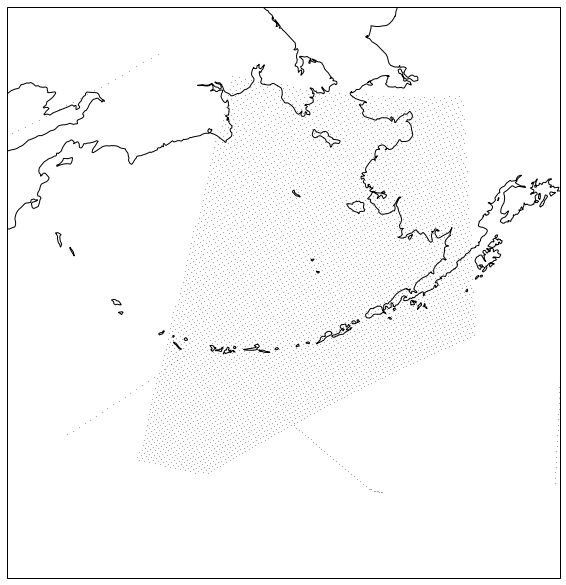

In [27]:
extent = [170, 210, 40, 68]
projection=ccrs.LambertConformal(central_longitude=200.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

ax.plot(dfext.longitude,dfext.latitude,'k.',markersize=.25,transform=transformation)
ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [28]:
new_days = open('BS_iceextent.csv','a')
new_days.write((filein+','+str((dfext.count()*(25*25))['ice_conc'])+'\n'))
print(filein,(dfext.count()*(25*25))['ice_conc'])
new_days.close()

/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/1978/bt_19781231_n07_v3.1_n.csv 3438750


### Define boundaries and cycle through all Bootstrap/NRT data

BS - 178E to Alaska

All BS to Russian land

We want to compare to the Daily Bering Sea ice extent during the past fourty years (data from the NSIDC Regional Sea Ice Index) which does a more comprehensive job of masking out the basin then the simple grid.  A 5day trailing average is applied to the regional extent product.

In [29]:
import glob
for y in range(2019,2020):
    year=str(y)
    #path = "/Users/bell/in_and_outbox/data_sets/gsfc_bootstrap_seaice_v3/daily/"+year+"/*.csv"
    path = "/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/*"+year+"*.csv"
    for fname in sorted(glob.glob(path)):
        df = pd.read_csv(fname)

        ### set a range of lats and lons - 178E to 155W
        dfext = df.copy()
        dfext.drop(dfext.loc[((dfext['latitude']<=45) | (dfext['latitude']>=65.6666))].index, inplace=True)
        #178E for BS boundary by Phyllis
        #165E for BS total boundary (estimate to not include any Sea of Oktosk)
        dfext.drop(dfext.loc[((dfext['longitude']>-155) & (dfext['longitude']<178))].index, inplace=True)
        dfext.drop(dfext.loc[dfext['ice_conc']<15].index, inplace=True)
        dfext.drop(dfext.loc[dfext['ice_conc']==np.nan].index, inplace=True)

        new_days = open("BS_iceextent."+year+".csv",'a')
        new_days.write((fname+','+str(dfext['grid_area'].sum())+'\n'))
        print(fname,(dfext['grid_area'].sum()))
        new_days.close()

/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190101_f18_nrt_n.csv 369610.06299999997
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190102_f18_nrt_n.csv 371742.642
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190103_f18_nrt_n.csv 384621.463
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190104_f18_nrt_n.csv 376463.74
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190105_f18_nrt_n.csv 381731.742
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190106_f18_nrt_n.csv 381436.17000000004
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190107_f18_nrt_n.csv 372179.32899999997
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190108_f18_nrt_n.csv 379773.952
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190109_f18_nrt_n.csv 382712.162
/Users/bell/in_and_outbox/data_sets/nrt_nasatime_seaice/nt_20190110_f18_nrt_n.csv 378445.371
/Users/bell/in_and_outbox/data_sets/nrt_nasatim

In [30]:
for y in range(2019,2020):
    year=str(y)

    fin = 'BS_iceextent.'+year+'.csv'
    fid = pd.read_csv(fin,names=['file','ice_extent'])
    fid['doy'] = fid['file']

    for index, rows in fid.iterrows():
        fid['doy'][index] = int(datetime.datetime.strptime(rows['doy'].split('nt_')[-1].split('_')[0],
                                                           '%Y%m%d').strftime('%j'))
    fid = fid.merge(how='right', 
              on='doy', 
              right = pd.DataFrame({'doy':np.arange(fid.iloc[0]['doy'], 
                                                    367, 
                                                    1)})).reset_index().drop(['index'], 
                                                                             axis=1).sort_values(by=['doy'])
    fid.to_csv(fin.replace('.csv','doy.csv'),columns=['doy','ice_extent'])


/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
